<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/vix-strategies/spy-vix/vix_spy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  2 of 2 completed
<ipython-input-117-1344708614>:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Entry_Price'].ffill(inplace=True)
<ipython-input-117-1344708614>:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

Total entries triggered: 22


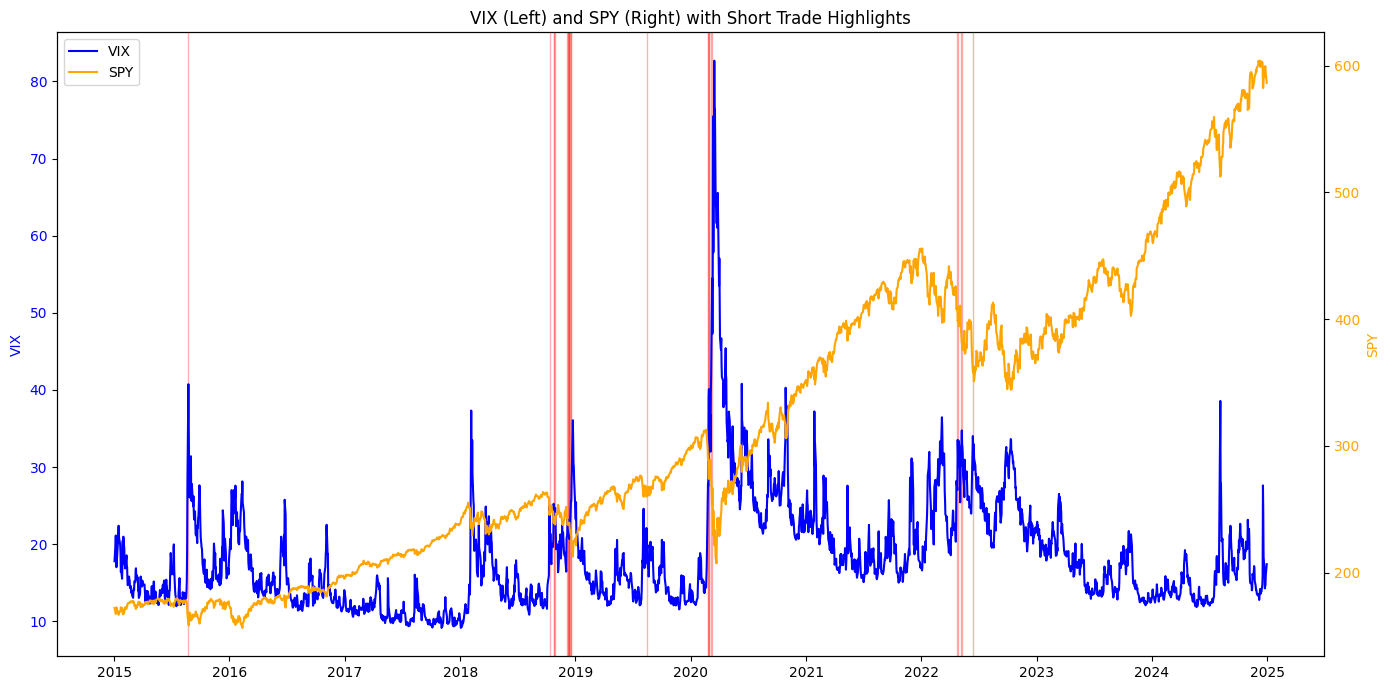

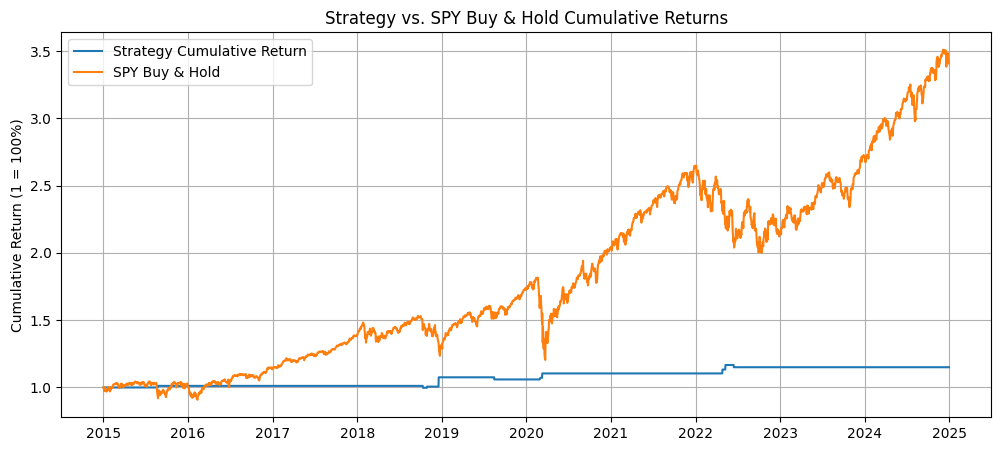

Total trades: 22
Winning trades: 7
Losing trades: 15
Win rate: 31.82%
Total strategy return: 15.04%


In [117]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download data
tickers = ['^VIX', 'SPY']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31', auto_adjust=True)['Close']
data = data.rename(columns={'^VIX': 'VIX', 'SPY': 'SPY'})

# 2. Calculate daily % changes
data['VIX_pct'] = data['VIX'].pct_change() * 100
data['SPY_pct'] = data['SPY'].pct_change() * 100

# PARAMETERS
VIX_RISE_THRESHOLD = 20       # VIX rise % to signal fear spike #20
SPY_FALL_THRESHOLD = -2.5      # SPY drop % for entry
SPY_RECOVER_EXIT = 2.0       # SPY gain % to exit
VIX_DROP_EXIT = -5.0        # VIX drop % to exit
MAX_HOLD_DAYS = 10       # max holding period
STOP_LOSS = -2.0               # stop loss % from entry price

# Prepare columns
data['Position'] = 0
data['Entry_Price'] = np.nan
data['Exit_Price'] = np.nan
data['Trade_Return'] = np.nan
data['In_Trade'] = False
data['Days_In_Trade'] = 0

# 3. Backtesting loop
in_trade = False
entry_idx = None
entry_price = None

# Debug counter
entry_count = 0

for i in range(1, len(data)):
    if not in_trade:
        if (data['VIX_pct'].iloc[i] >= VIX_RISE_THRESHOLD) and (data['SPY_pct'].iloc[i] <= SPY_FALL_THRESHOLD):
            entry_idx = i + 1 if i + 1 < len(data) else i
            entry_price = data['SPY'].iloc[entry_idx]
            data.at[data.index[entry_idx], 'Position'] = -1
            data.at[data.index[entry_idx], 'Entry_Price'] = entry_price
            data.at[data.index[entry_idx], 'In_Trade'] = True
            data.at[data.index[entry_idx], 'Days_In_Trade'] = 1
            in_trade = True
            entry_count += 1
            # print(f"Entry at {data.index[entry_idx].date()} | SPY: {entry_price:.2f} | VIX%: {data['VIX_pct'].iloc[i]:.2f} | SPY%: {data['SPY_pct'].iloc[i]:.2f}")
    else:
        current_idx = i
        current_price = data['SPY'].iloc[current_idx]
        days_held = data['Days_In_Trade'].iloc[current_idx - 1] + 1

        data.at[data.index[current_idx], 'In_Trade'] = True
        data.at[data.index[current_idx], 'Days_In_Trade'] = days_held
        data.at[data.index[current_idx], 'Position'] = -1

        ret_pct = (entry_price - current_price) / entry_price * 100

        spy_recover = (current_price - entry_price) / entry_price * 100 >= SPY_RECOVER_EXIT
        vix_drop = data['VIX_pct'].iloc[current_idx] <= VIX_DROP_EXIT
        max_days = days_held >= MAX_HOLD_DAYS
        stop_loss_hit = ret_pct <= STOP_LOSS

        if spy_recover or vix_drop or max_days or stop_loss_hit:
            data.at[data.index[current_idx], 'Exit_Price'] = current_price
            data.at[data.index[current_idx], 'Trade_Return'] = ret_pct / 100
            data.at[data.index[current_idx], 'Position'] = 0
            in_trade = False
            entry_idx = None
            entry_price = None
            #print(f"Exit at {data.index[current_idx].date()} | Return: {ret_pct:.2f}%")

print(f"Total entries triggered: {entry_count}")

# Fill forward for plotting
data['Entry_Price'].ffill(inplace=True)
data['In_Trade'].fillna(False, inplace=True)

# 4. Calculate Strategy returns
data['Strategy_Return'] = 0.0
exit_days = data['Exit_Price'].notna()
data.loc[exit_days, 'Strategy_Return'] = data.loc[exit_days, 'Trade_Return']
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod().fillna(method='ffill').fillna(1)

# Buy & Hold
data['SPY_Return'] = data['SPY'].pct_change().fillna(0)
data['Cumulative_SPY'] = (1 + data['SPY_Return']).cumprod()

# 5. Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# VIX on LEFT Y-axis (blue)
ax1.plot(data.index, data['VIX'], label='VIX', color='blue')
ax1.set_ylabel('VIX', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Short trade highlights
for i in range(len(data)):
    if data['Position'].iloc[i] == -1:
        ax1.axvspan(data.index[i], data.index[i], color='red', alpha=0.3)

# SPY on RIGHT Y-axis (orange)
ax2 = ax1.twinx()
ax2.plot(data.index, data['SPY'], label='SPY', color='orange')
ax2.set_ylabel('SPY', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Merge both legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('VIX (Left) and SPY (Right) with Short Trade Highlights')
fig.tight_layout()
plt.show()


# Cumulative returns
plt.figure(figsize=(12, 5))
plt.plot(data['Cumulative_Strategy'], label='Strategy Cumulative Return')
plt.plot(data['Cumulative_SPY'], label='SPY Buy & Hold')
plt.title('Strategy vs. SPY Buy & Hold Cumulative Returns')
plt.ylabel('Cumulative Return (1 = 100%)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Performance Summary
total_trades = data['Trade_Return'].count()
winning_trades = (data['Trade_Return'] > 0).sum()
losing_trades = (data['Trade_Return'] <= 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0
total_return = data['Cumulative_Strategy'].iloc[-1] - 1

print(f"Total trades: {total_trades}")
print(f"Winning trades: {winning_trades}")
print(f"Losing trades: {losing_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Total strategy return: {total_return:.2%}")

